In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_ap_ars, plot_performance

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from models.setup import ModelSetup
from data.paths import MIMIC_EYE_PATH
# from data.load import seed_worker, get_dataloader_g

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [5]:
common_args = {
    "sources": ["xrays", "clinical"],
    # "tasks": ["object-detection", "heatmap-generation"],
    "tasks": [
        "lesion-detection",
        "fixation-generation",
        "chexpert-classification",
        "negbio-classification",
    ],
    "decoder_channels": [128, 64, 32, 16, 1],
    "optimiser": "sgd",
    "lr": 1e-3,  # should multiply by 8 or just use 1e-2, to test if it will explode.
    "batch_size": 16,
    "weight_decay": 1e-9,  # 1E-5
    # "pretrained": True,
    "record_training_performance": True,
    "image_size": 512,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",
    "reduceLROnPlateau_factor": 0.1,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": True,
    "multiStepLR_milestones": 100,
    "multiStepLR_gamma": 0.1,
    "use_mask": False,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "measure_test": True,
    "fiaxtions_mode": "reporting",
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "representation_size": 64,  # 32
    # "clinical_input_channels": 64,
    # "clinical_conv_channels": 64,
    # "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}


In [6]:
all_model_setups = [
    ModelSetup(
        name="basline_test",
        **mobilenet_args,
        **small_model_args,
        **common_args,
    )
]

In [7]:
num_epochs = 30
train_infos = []

In [8]:
from models.components.task_performers import ObjectDetectionPerformer
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS, DEFAULT_MIMIC_CLINICAL_CAT_COLS
from sklearn.metrics import roc_auc_score

In [9]:
########### Each task has one target, they it won't be difficult again.

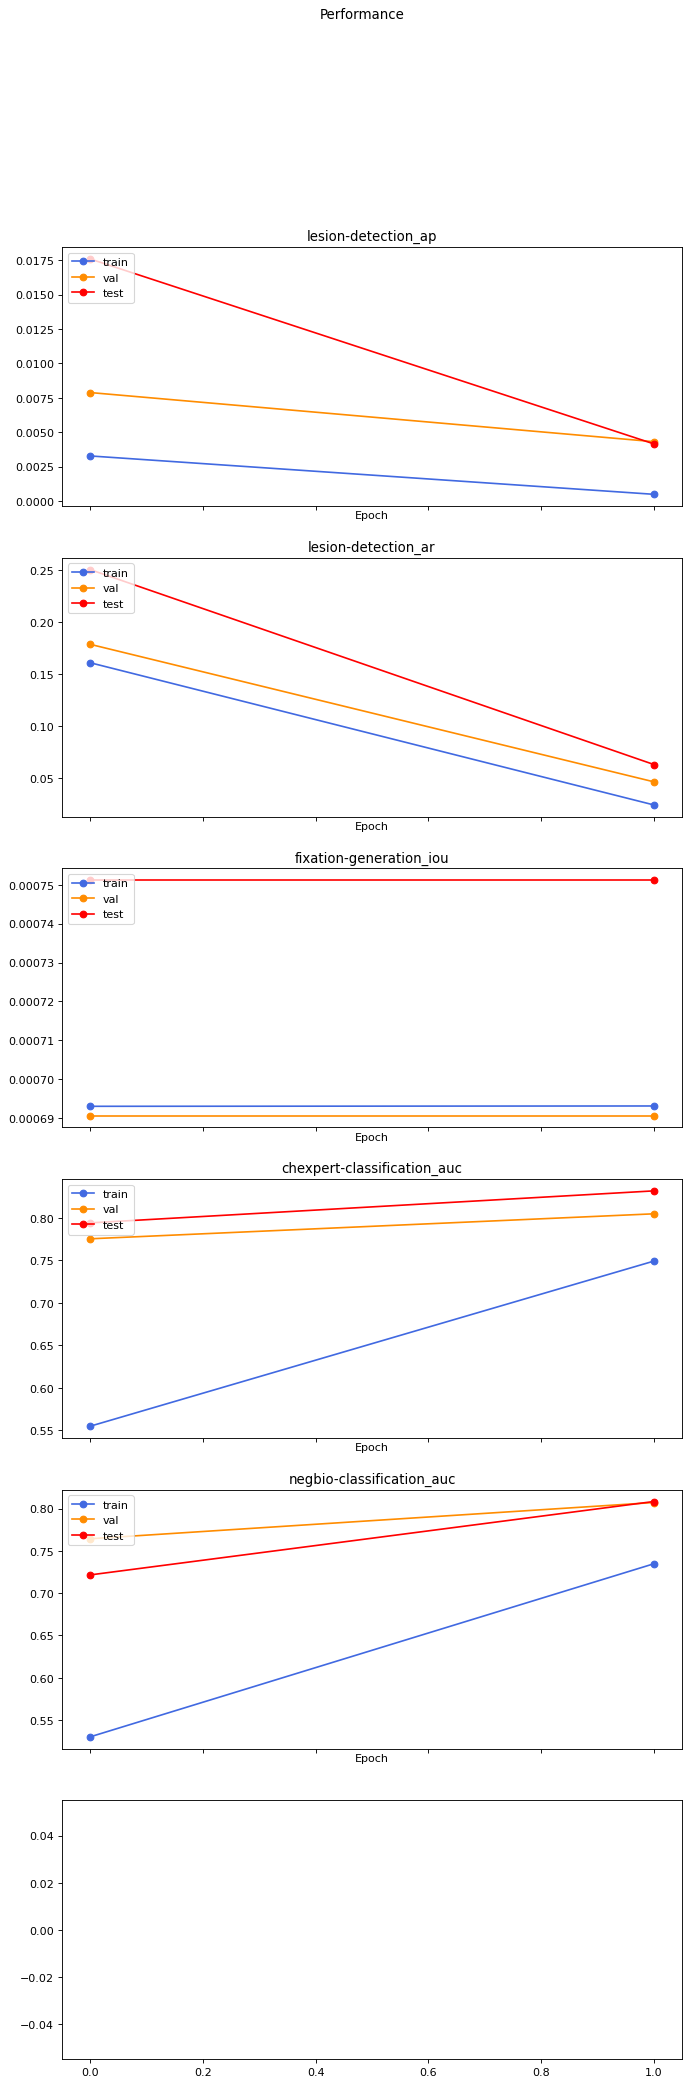

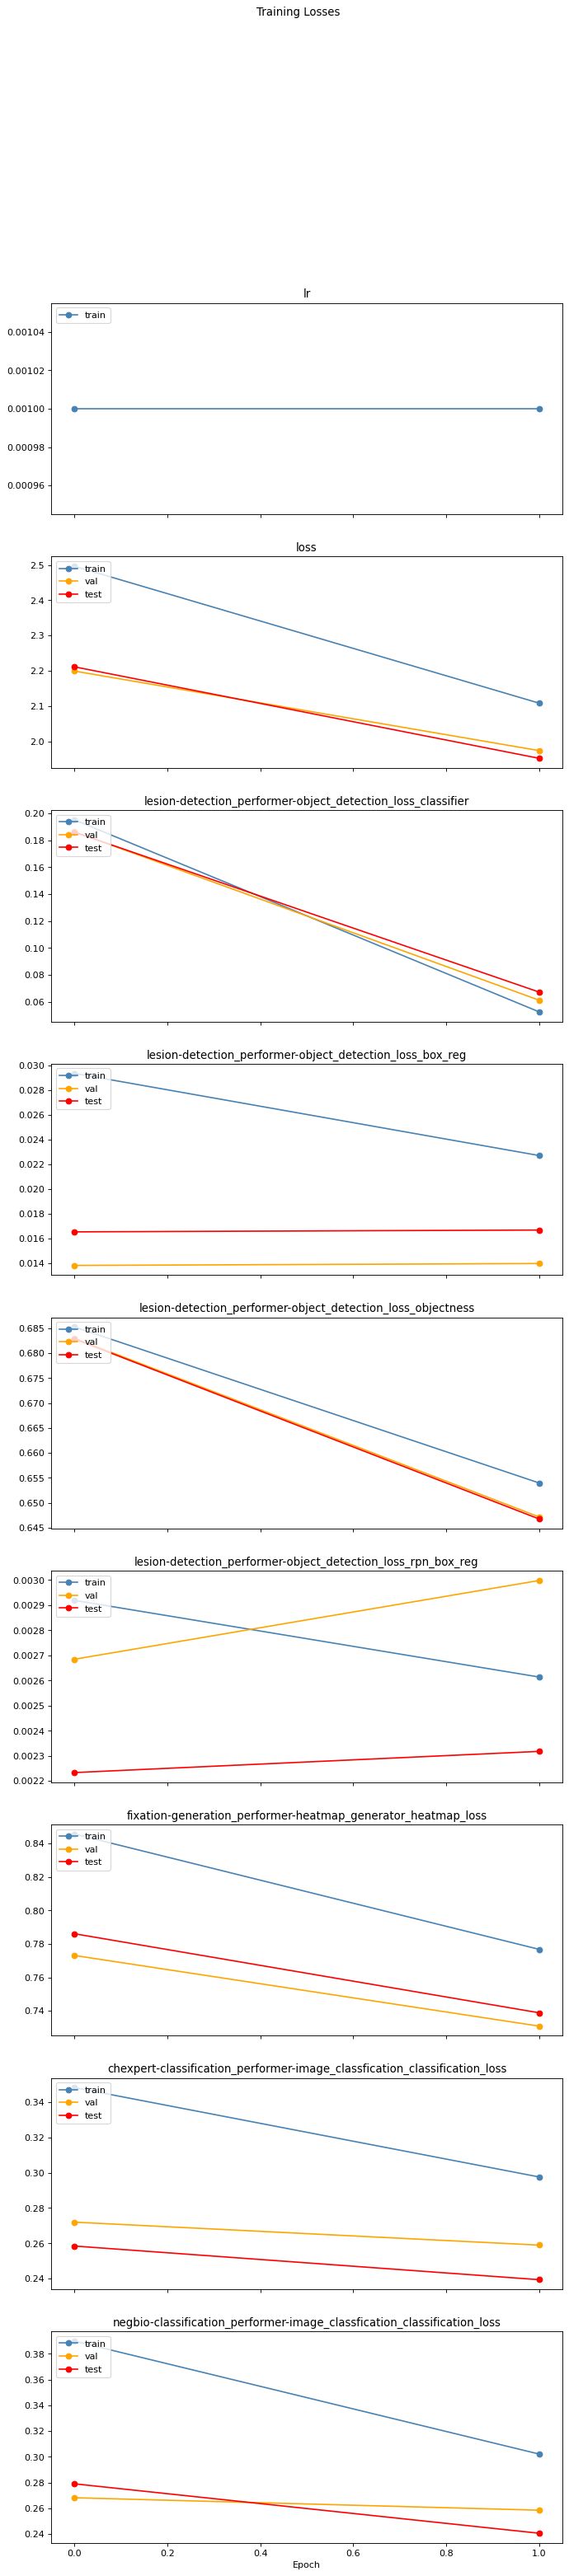

====================| Epoch [2] Done | It has took [11.00] min, Avg time: [330.00] sec/epoch | Estimate time for [30] epochs: [165.00] min | Epoch took [312] sec | Patience [0] |====================
====================Training model: [basline_test]====================
========================================For Training [basline_test]========================================
ModelSetup(name='basline_test', sources=['xrays', 'clinical'], tasks=['lesion-detection', 'fixation-generation', 'chexpert-classification', 'negbio-classification'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 1], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-09, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, backbone_out_channels=64, batch_size=16, warmup_e

In [10]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.

for setup in all_model_setups:
    assert (
        len(setup.sources) > 0 and len(setup.tasks) > 0
    ), "Need at least one source and task."

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(setup)

    if setup.measure_test:
        # initialise the test recording list.
        train_info.test_ap_ars = []

    model = create_model_from_setup(setup=setup)
    model = model.to(device)
    print(f" Model Size [{get_model_size_in_MB(model):.3f}] MB")

    ################ Datasets ################
    dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "labels_cols": setup.lesion_label_cols,
        "with_fixations": "fixation-generation" in setup.tasks,
        "fiaxtions_mode": setup.fiaxtions_mode,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=setup.batch_size,
    )

    train_coco = None
    train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
        train_dataloader,
        val_dataloader,
        test_dataloader,
        detect_eval_dataset,
        setup.iou_thrs,
        setup.use_iobb,
    )

    train_info.timer.start_training()

    dynamic_loss_weight = get_dynamic_loss(
        loss_keys=model.get_all_losses_keys(), device=device
    )
    params = model.get_all_params(dynamic_loss_weight=dynamic_loss_weight)

    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)
    lr_scheduler = get_lr_scheduler(optimizer, setup)

    print_f.print_title(
        f"Start training. Preparing Took [{train_info.timer.has_took_sec_from_init()}] sec"
    )

    train_info.timer.start_training()

    val_loss = None

    # Start the training from here.
    for e in range(1, num_epochs + 1):

        print_f.print_title(f"Training model: [{setup.name}]")

        print(train_info)

        train_info.epoch = e

        train_info.timer.start_epoch()

        if (
            any(
                [
                    isinstance(p, ObjectDetectionPerformer)
                    for p in model.task_performers.values()
                ]
            )
            and train_info.epoch > setup.gt_in_train_till
        ):
            model.task_performers["lesion-detection"].roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator["lesion-detection"],
            train_info.last_val_evaluator["lesion-detection"],
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.performance["train"].append(
            {
                "lesion-detection": train_ap_ar,
                "fixation-generation": {
                    "iou": train_info.last_train_evaluator[
                        "fixation-generation"
                    ].get_iou()
                },
                "chexpert-classification": {
                    "auc": train_info.last_train_evaluator[
                        "chexpert-classification"
                    ].get_clf_score(roc_auc_score)
                },
                "negbio-classification": {
                    "auc": train_info.last_train_evaluator[
                        "negbio-classification"
                    ].get_clf_score(roc_auc_score)
                },
            }
        )

        train_info.performance["val"].append(
            {
                "lesion-detection": val_ap_ar,
                "fixation-generation": {
                    "iou": train_info.last_val_evaluator[
                        "fixation-generation"
                    ].get_iou()
                },
                "chexpert-classification": {
                    "auc": train_info.last_val_evaluator[
                        "chexpert-classification"
                    ].get_clf_score(roc_auc_score)
                },
                "negbio-classification": {
                    "auc": train_info.last_val_evaluator[
                        "negbio-classification"
                    ].get_clf_score(roc_auc_score)
                },
            }
        )

        # train_info.train_ap_ars.append(train_ap_ar)
        # train_info.val_ap_ars.append(val_ap_ar)

        if setup.measure_test:
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))

            test_ap_ar = get_ap_ar(
                train_info.test_evaluator['lesion-detection'], areaRng="all", iouThr=0.5, maxDets=10,
            )
            # train_info.test_ap_ars.append(test_ap_ar)

            train_info.performance["test"].append(
                {
                    "lesion-detection": test_ap_ar,
                    "fixation-generation": {
                        "iou": train_info.test_evaluator[
                            "fixation-generation"
                        ].get_iou()
                    },
                    "chexpert-classification": {
                        "auc": train_info.test_evaluator[
                            "chexpert-classification"
                        ].get_clf_score(roc_auc_score)
                    },
                    "negbio-classification": {
                        "auc": train_info.test_evaluator[
                            "negbio-classification"
                        ].get_clf_score(roc_auc_score)
                    },
                }
            )

        # update the learning rate

        val_loss = train_info.val_losses[-1]["loss"]

        epoch_took, sec_already_took, speed = train_info.timer.end_epoch(
            train_info.epoch
        )

        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        # plot all matrics
        plot_performance(
            performance=train_info.performance,
            all_tasks=list(model.task_performers.keys()),
            fig_title="Performance",
        )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        # previous_time = current_time
        # current_time = datetime.now()
        # epoch_took = current_time - previous_time

        # sec_took = (current_time - train_info.start_t).seconds
        # speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        if setup.save_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                setup=setup,
                val_ap_ar=val_ap_ar,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )

    val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ap_ar["ar"],
        last_val_ap=val_ap_ar["ap"],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)


## TODO: allow for any kind of pipeline.

In [ ]:
from utils.plot import performance_list, split_to_colour

In [ ]:
all_tasks = list(model.task_performers.keys())
performance = train_info.performance

NameError: name 'model' is not defined

In [ ]:
all_p_list = {
    "train": performance_list(
        all_tasks=all_tasks, performance=performance, split="train"
    ),
    "val": performance_list(
        all_tasks=all_tasks, performance=performance, split="val"
    ),
    "test": performance_list( all_tasks=all_tasks, performance=performance, split="test"),
}

In [ ]:
performance

{'train': [{'lesion-detection': {'ap': 0.004073390785737503,
    'ar': 0.17199693625562706},
   'fixation-generation': {'iou': 0.0006929590732236452},
   'chexpert-classification': {'auc': 255.0},
   'negbio-classification': {'auc': 333.0}}],
 'val': [{'lesion-detection': {'ap': 0.0038408163370742395,
    'ar': 0.1725655935564238},
   'fixation-generation': {'iou': 0.0006905732331452546},
   'chexpert-classification': {'auc': 41.5},
   'negbio-classification': {'auc': 6.5}}],
 'test': [{'lesion-detection': {'ap': 0.011448739557065045,
    'ar': 0.25863012693521165},
   'fixation-generation': {'iou': 0.0007511868196375229},
   'chexpert-classification': {'auc': 44.0},
   'negbio-classification': {'auc': 6.5}}]}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
all_p_list['train']

NameError: name 'all_p_list' is not defined

In [ ]:
p_list

NameError: name 'p_list' is not defined

In [ ]:
num_p = 0
for t in all_tasks:
    for s, p_list in all_p_list.items():
        if p_list is not None:
            for k, v in p_list[t].items():
                num_p += 1

NameError: name 'all_tasks' is not defined

[0.004073390785737503]
[0.17199693625562706]
[0.0038408163370742395]
[0.1725655935564238]
[0.011448739557065045]
[0.25863012693521165]
[{'iou': 0.0006929590732236452}]


TypeError: float() argument must be a string or a number, not 'dict'

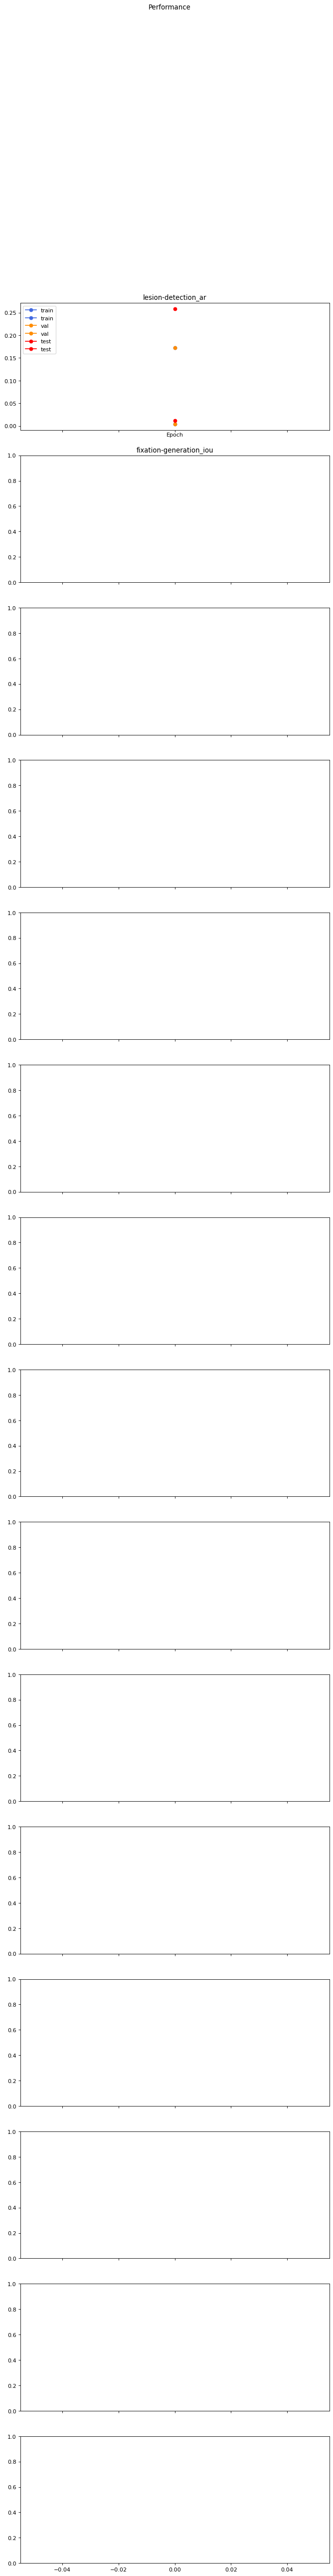

In [ ]:
fig_title = "Performance"

num_p = 0
for t in all_tasks:
    for s, p_list in all_p_list.items():
        if p_list is not None:
            for k, v in p_list[t].items():
                num_p += 1

fig, axes = plt.subplots(num_p, figsize=(10, 5*num_p), dpi=80, sharex=True,)

if fig_title:
    fig.suptitle(f"{fig_title}")


current_idx = 0
for t in all_tasks:
    for s, p_list in all_p_list.items():
        if p_list is not None:
            for k, v in p_list[t].items():
                axes[current_idx].set_title(f"{t}_{k}")
                print(v)
                axes[current_idx].plot(
                    v, marker="o", label=s, color=split_to_colour[s],
                )
    axes[current_idx].legend(loc="upper left")
    axes[current_idx].set_xlabel("Epoch")
    current_idx += 1

plt.plot()
plt.pause(0.01)


In [ ]:
num_p

15

In [ ]:
train_info.performance['train'][0].keys()

dict_keys(['lesion-detection', 'fixation-generation:', 'chexpert-classification', 'negbio-classification'])

In [ ]:
train_info.performance['train'][0]['fixation-generation']

KeyError: 'fixation-generation'

In [ ]:
fixation-generation
train_info.last_train_evaluator['fixation-generation']

In [ ]:
['negbio_classification']
negbio-classification

In [ ]:
train_info.last_train_evaluator['negbio-classification']

In [ ]:
train_info.last_val_evaluator['lesion-detection'].synchronize_between_processes()
train_info.last_val_evaluator['lesion-detection'].accumulate()
train_info.last_val_evaluator['lesion-detection'].summarize()


DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ] = 0.005
 Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area= small | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area=medium | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area= large | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoBB=0.50:0.50 | area=   all | maxDets=  1 ] = 0.070
 Average Recall     (AR) @[ IoBB=0.50:0.50 | area=   all | maxDets= 10 ] = 0.193
 Average Recall     (AR) @[ IoBB=0.50:0.50 | area=   all | maxDets= 10 ] = 0.193
 Average Recall     (AR) @[ IoBB=0.50:0.50 | area= small | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoBB=0.50:0.50 | area=medium | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoBB=0.50:0.50 | area= large | maxDets= 10

In [ ]:

train_info.last_train_evaluator["lesion-detection"].eval

AttributeError: 'CocoEvaluator' object has no attribute 'eval'

In [ ]:
train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
    train_info.last_train_evaluator["lesion-detection"],
    train_info.last_val_evaluator["lesion-detection"],
    areaRng="all",
    iouThr=0.5,
    maxDets=10,
)

KeyError: 'precision'

In [ ]:
        for e in evaluators:
            if isinstance(e, CocoEvaluator):
                e.synchronize_between_processes()
                e.accumulate()
                e.summarize()

In [ ]:
train_info.last_train_evaluator["lesion-detection"]

In [ ]:
o_s = [o for o in model.evaluators['fixation-generation'].outputs]
    

In [ ]:
o_s[0].shape

torch.Size([1, 512, 512])

In [ ]:
model.evaluators['chexpert-classification'].outputs.shape

torch.Size([16, 14])

In [ ]:
model.evaluators['chexpert-classification'].targets

[{'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.],
         device='cuda:0', dtype=torch.float64)},
 {'classifications': tensor([0., 0., 0., 

In [ ]:
preds = model.evaluators['chexpert-classification'].preds

In [ ]:
gts = model.evaluators['chexpert-classification'].gts

In [ ]:
from sklearn.metrics import accuracy_score, auc, average_precision_score, recall_score, f1_score, precision_score

In [ ]:
gts

[array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False]),
 array([False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False,  True]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False]),
 array([False, False, False, False, False, False, False,  True, False,
         True, False, False,  True,  True]),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
 

In [ ]:
precision_score(np.array(gts).reshape(-1), (np.array(preds)>0.5).reshape(-1))

0.06542056074766354

In [ ]:
np.array(gts).reshape(-1, 1)

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [ ]:
accuracy_score(np.array(gts), np.array(preds)>0.5)

0.0

In [ ]:
accuracy_score(np.array(gts)[0:2],np.array(preds)[0:2]>0.5 )


0.0

array([ True, False, False,  True,  True,  True, False, False, False,
        True,  True, False,  True, False])

In [ ]:
accuracy_score(np.array([True]),np.array([0]))

0.0

In [ ]:
np.array(gts).shape

(16, 14)

In [ ]:
(np.array(preds)>0.5).shape

(16, 14)

In [ ]:
# intersection = np.logical_and(target, prediction)
# union = np.logical_or(target, prediction)
# iou_score = np.sum(intersection) / np.sum(union)


In [ ]:
np.sum(intersection)

1364

0.0011023300056005477

In [ ]:
roi_heads = model.task_performers['lesion-detection'].roi_heads

In [ ]:
roi_heads.proposals_in_image

tensor([], device='cuda:0', size=(0, 4))

In [ ]:
roi_heads.gt_boxes_in_image

tensor([[162.5131, 289.4088, 425.0471, 505.1572],
        [162.5131, 289.4088, 425.0471, 505.1572],
        [115.7696, 221.5849, 195.0157, 374.9434],
        [115.7696, 221.5849, 195.0157, 374.9434]], device='cuda:0',
       dtype=torch.float64)

In [ ]:
roi_heads.proposals

[tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4)),
 tensor([], device='cuda:0', size=(0, 4))]

In [ ]:
for p in roi_heads.proposals:
  print(p.numel())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
roi_heads.gt_boxes

[tensor([[162.5131, 289.4088, 425.0471, 505.1572],
         [162.5131, 289.4088, 425.0471, 505.1572],
         [115.7696, 221.5849, 195.0157, 374.9434],
         [115.7696, 221.5849, 195.0157, 374.9434]], device='cuda:0',
        dtype=torch.float64),
 tensor([], device='cuda:0', size=(0, 4), dtype=torch.float64),
 tensor([], device='cuda:0', size=(0, 4), dtype=torch.float64),
 tensor([], device='cuda:0', size=(0, 4), dtype=torch.float64),
 tensor([[298.7225, 249.9623, 467.7696, 374.3396]], device='cuda:0',
        dtype=torch.float64),
 tensor([], device='cuda:0', size=(0, 4), dtype=torch.float64),
 tensor([[ 48.6149, 247.1398, 191.7589, 370.2372],
         [ 48.6149, 247.1398, 191.7589, 370.2372],
         [325.2570, 252.1015, 457.2117, 386.3036],
         [325.2570, 252.1015, 457.2117, 386.3036]], device='cuda:0',
        dtype=torch.float64),
 tensor([[328.2516, 291.0157, 422.2390, 357.1937],
         [328.2516, 291.0157, 422.2390, 357.1937],
         [328.2516, 291.0157, 422.2390,

In [ ]:
roi_heads.gt_labels

[tensor([1, 2, 1, 2], device='cuda:0'),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([4], device='cuda:0'),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([3, 4, 3, 4], device='cuda:0'),
 tensor([3, 4, 5, 3, 4, 5], device='cuda:0'),
 tensor([1, 2, 1, 2, 1, 2], device='cuda:0'),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([2], device='cuda:0'),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64)]

In [ ]:
roi_heads = model.task_performers['lesion-detection'].roi_heads

In [ ]:
features = list(rpn.features.values())

In [ ]:
features[0]

tensor([[[[ 4.5371e-01,  1.1107e+00,  1.0653e+00,  ...,  1.2993e+00,
           -1.5908e-01, -4.0192e-01],
          [-1.2164e+00,  1.3239e+00, -1.3515e-01,  ...,  1.0273e+00,
            9.6238e-01,  3.1196e-01],
          [-2.2418e-01,  1.5499e+00,  8.2599e-01,  ..., -3.0881e-02,
            5.2185e-02,  5.7094e-01],
          ...,
          [ 2.4872e-01,  8.4924e-01,  1.1669e-01,  ..., -1.7784e-01,
           -6.6055e-01,  1.0918e+00],
          [-8.5080e-02, -5.5585e-01,  7.9283e-01,  ...,  1.5807e-01,
           -6.9216e-01,  2.4333e-01],
          [-1.4943e-01, -6.1143e-02,  7.3562e-01,  ...,  3.2373e-01,
           -2.2353e-01,  3.0162e-01]],

         [[-1.5025e+00, -7.3002e-02,  7.3577e-01,  ..., -1.0874e+00,
           -3.4808e-01, -2.8470e-01],
          [ 1.3282e+00, -2.0872e-01,  3.5579e-01,  ..., -6.6279e-01,
            1.0678e-01,  2.2035e+00],
          [ 1.6927e+00,  6.3251e-01,  1.6392e+00,  ...,  1.2862e+00,
            1.3110e-02,  8.3780e-01],
          ...,
     

In [ ]:
rpn.proposals

AttributeError: 'XAMIRegionProposalNetwork' object has no attribute 'proposals'

In [ ]:
rpn.objectness[0].shape

torch.Size([16, 15, 16, 16])

In [ ]:
16*16*15

3840

In [ ]:
num_anchors_per_level_shape_tensors = [o[0].shape for o in rpn.objectness]


In [ ]:
num_anchors_per_level_shape_tensors

[torch.Size([15, 16, 16])]

In [ ]:
rpn.features['0'].shape

torch.Size([16, 64, 16, 16])

In [ ]:
rpn.num_images

1

In [ ]:
rpn.proposals.shape

torch.Size([1, 61440, 4])

In [ ]:
rpn.objectness[0][0].shape

torch.Size([])

In [ ]:
rpn.features['0'].shape

# 3840 came from?

torch.Size([16, 64, 16, 16])

In [ ]:
len(rpn.features['0'])

16

In [ ]:
rpn.num_anchors_per_level

[3840]

In [ ]:
rpn.objectness.shape

torch.Size([61440, 1])

In [ ]:
rpn.targets

[{'lesion-detection': {'boxes': tensor([], device='cuda:0', size=(0, 4), dtype=torch.float64),
   'labels': tensor([], device='cuda:0', dtype=torch.int64),
   'image_id': tensor([277], device='cuda:0'),
   'area': tensor([], device='cuda:0', dtype=torch.float64),
   'iscrowd': tensor([], device='cuda:0', dtype=torch.int64),
   'dicom_id': 'd1ba2452-7b220f77-f6c95da1-609c2166-eddc3a3a',
   'image_path': 'D:\\mimic-eye\\patient_13649350\\CXR-JPG\\s53326963\\d1ba2452-7b220f77-f6c95da1-609c2166-eddc3a3a.jpg',
   'original_image_sizes': (3056, 2544)},
  'chexpert-classification': {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          device='cuda:0', dtype=torch.float64)},
  'negbio-classification': {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          device='cuda:0', dtype=torch.float64)},
  'fixation-generation': {'heatmaps': tensor([[[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
          

In [ ]:
from data.utils import chain_map

In [ ]:
chain_map([{"a": 5, "b": 6,}, {"a": 7, "b": 8,}])



{'a': [5, 7], 'b': [6, 8]}

In [ ]:
[(2,3)]*40

[(2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3)]

In [ ]:
train_dataset.targets

[{'lesion-detection': {'boxes': tensor([], size=(0, 4), dtype=torch.float64),
   'labels': tensor([], dtype=torch.int64),
   'image_id': tensor([277]),
   'area': tensor([], dtype=torch.float64),
   'iscrowd': tensor([], dtype=torch.int64),
   'dicom_id': 'd1ba2452-7b220f77-f6c95da1-609c2166-eddc3a3a',
   'image_path': 'D:\\mimic-eye\\patient_13649350\\CXR-JPG\\s53326963\\d1ba2452-7b220f77-f6c95da1-609c2166-eddc3a3a.jpg'},
  'chexpert-classification': {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          dtype=torch.float64)},
  'negbio-classification': {'classifications': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          dtype=torch.float64)},
  'fixation-generation': {'heatmaps': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
         

In [ ]:
train_dataset.inputs

AttributeError: 'ReflacxDataset' object has no attribute 'inputs'

In [ ]:
model.inputs

AttributeError: 'ExtractFusePerform' object has no attribute 'inputs'

In [ ]:
model.targets

AttributeError: 'ExtractFusePerform' object has no attribute 'targets'

In [ ]:
# only stack the things when they need to be stacked.

In [ ]:
# model.task_performers['lesion-detection'].rpn.targets

In [ ]:
c = model.feature_extractors['clinical']

In [ ]:
c.all_cols

['gender',
 'age',
 'temperature',
 'heartrate',
 'resprate',
 'o2sat',
 'sbp',
 'dbp',
 'pain',
 'acuity']

In [ ]:
len(c.all_cols)

10

In [ ]:
c.embedding_dim

32

In [ ]:
c.categorical_col_maps

{'gender': 2}

In [ ]:
model.feature_extractors.keys()

odict_keys(['xrays', 'clinical'])

In [ ]:
targets = model.task_performers['lesion-detection'].transform.targets

In [ ]:
lesion_detection_target_index = (
                targets["fixation_generation"][0]
                if "fixation_generation" in targets
                and targets["fixation_generation"] is not None
                else None
            )

In [ ]:
targets.keys()

dict_keys(['fixation-generation', 'fixation_path', 'negbio-classification', 'chexpert-classification', 'lesion-detection'])

In [ ]:
"fixation_generation" ==

In [ ]:
"fixation_generation" in targets.keys() 'fixation-generation'

False

In [ ]:
lesion_detection_target_index

In [ ]:
targets["lesion-detection"]

TypeError: 'dict_keys' object is not subscriptable

In [ ]:
lesion_detection_target_index 

{'boxes': tensor([], size=(0, 4), dtype=torch.float64),
 'labels': tensor([], dtype=torch.int64),
 'image_id': tensor([277]),
 'area': tensor([], dtype=torch.float64),
 'iscrowd': tensor([], dtype=torch.int64),
 'dicom_id': 'd1ba2452-7b220f77-f6c95da1-609c2166-eddc3a3a',
 'image_path': 'D:\\mimic-eye\\patient_13649350\\CXR-JPG\\s53326963\\d1ba2452-7b220f77-f6c95da1-609c2166-eddc3a3a.jpg'}

In [ ]:
lesion_detection_target_index = (
                targets["lesion-detection"][i]
                if "lesion-detection" in targets
                and targets["lesion-detection"] is not None
                else None
            )

In [ ]:
for k_1 in model.targets.keys():
    for k_2 in model.targets[k_1].keys():
        if isinstance(model.targets[k_1][k_2], torch.Tensor):
            model.targets[k_1][k_2] = model.targets[k_1][k_2].to(device)

        elif isinstance(model.targets[k_1][k_2], list):
            try:
                model.targets[k_1][k_2] = torch.stack(model.targets[k_1][k_2]).to(
                    device
                )
            except:
                model.targets[k_1][k_2] = [
                    e.to(device) if isinstance(e, torch.Tensor) else e
                    for e in model.targets[k_1][k_2]
                ]



lesion-detection_image_list_tensors_shape


In [ ]:
k_1

'lesion-detection'

In [ ]:
model.targets[k_1][k_2]

torch.Size([16, 3, 512, 512])

In [ ]:
k_1

'fixation-generation'

In [ ]:
k_2

'fixations'

In [ ]:
 model.inputs['xrays']['images'].shape

torch.Size([16, 3, 512, 512])

In [ ]:
 model.inputs[k_1][k_2]

tensor([[ 79.0000,  98.3000,  69.0000,  20.0000,  91.0000, 121.0000,  73.0000,
           2.0000],
        [ 60.0000,  97.8000,  81.0000,  16.0000, 100.0000, 161.0000,  85.0000,
           3.0000],
        [ 52.0000,  98.8000, 104.0000,  20.0000,  96.0000, 128.0000,  87.0000,
           2.0000],
        [ 39.0000,  98.2000,  73.0000,  16.0000, 100.0000, 133.0000,  89.0000,
           3.0000],
        [ 50.0000,  98.3000,  82.0000,  16.0000,  95.0000, 133.0000,  60.0000,
           2.0000],
        [ 55.0000,  99.6000,  68.0000,  18.0000, 100.0000, 108.0000,  69.0000,
           3.0000],
        [ 59.0000,  97.7000,  72.0000,  20.0000, 100.0000, 159.0000,  95.0000,
           3.0000],
        [ 58.0000,  98.2000,  89.0000,  20.0000,  99.0000, 126.0000,  77.0000,
           2.0000],
        [ 59.0000,      nan,      nan,      nan,      nan,      nan,      nan,
              nan],
        [ 77.0000,  97.9000,  62.0000,  18.0000, 100.0000, 137.0000, 107.0000,
           3.0000],
        [ 

In [ ]:
for k in model.feature_extractors.keys():
    print(k)

xrays


In [ ]:
model.x # xrays stacked but not xrays

{'xrays': [{'image': tensor([[[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            ...,
            [0.9176, 0.8902, 0.9608,  ..., 0.8627, 0.8863, 0.8667],
            [0.9647, 0.9529, 0.9569,  ..., 0.8863, 0.8863, 0.8784],
            [0.9529, 0.9373, 0.9529,  ..., 0.9255, 0.8941, 0.8784]],
   
           [[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            ...,
            [0.9176, 0.8902, 0.9608,  ..., 0.8627, 0.8863, 0.8667],
            [0.9647, 0.9529, 0.9569,  ..., 0.8863, 0.8863, 0.8784],
            [0.9529, 0.9373, 0.9529,  ..., 0.9255, 0.8941, 0.8784]],
   
           [[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0

{'xrays': {'image': [tensor([[[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            ...,
            [0.9176, 0.8902, 0.9608,  ..., 0.8627, 0.8863, 0.8667],
            [0.9647, 0.9529, 0.9569,  ..., 0.8863, 0.8863, 0.8784],
            [0.9529, 0.9373, 0.9529,  ..., 0.9255, 0.8941, 0.8784]],
   
           [[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            ...,
            [0.9176, 0.8902, 0.9608,  ..., 0.8627, 0.8863, 0.8667],
            [0.9647, 0.9529, 0.9569,  ..., 0.8863, 0.8863, 0.8784],
            [0.9529, 0.9373, 0.9529,  ..., 0.9255, 0.8941, 0.8784]],
   
           [[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
            [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0

In [ ]:
model.x.keys()

dict_keys(['xrays', 'clinical'])

In [ ]:
from data.utils import chain_map

In [ ]:
chain_map(model.x['clinical']).keys()

dict_keys(['cat', 'num'])

In [ ]:
chain_map(model.x['xrays']).keys()

dict_keys(['image'])

In [ ]:
model.feature_extractors

ModuleDict(
  (xrays): ImageFeatureExtractor(
    (backbone): Sequential(
      (0): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
              (activation): ReLU()
              (sc

In [ ]:
setup.sources

['xrays', 'clinical']

In [ ]:
model.inputs['xrays']['images'].shape

torch.Size([16, 3, 512, 512])

In [ ]:
from data.utils import chain_map

In [ ]:
chain_map(model.inputs['clinical'])

{'cat': [tensor([0], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([1], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([1], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([1], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([1], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([1], dtype=torch.int32),
  tensor([0], dtype=torch.int32),
  tensor([0], dtype=torch.int32)],
 'num': [tensor([ 79.0000,  98.3000,  69.0000,  20.0000,  91.0000, 121.0000,  73.0000,
            2.0000]),
  tensor([ 60.0000,  97.8000,  81.0000,  16.0000, 100.0000, 161.0000,  85.0000,
            3.0000]),
  tensor([ 52.0000,  98.8000, 104.0000,  20.0000,  96.0000, 128.0000,  87.0000,
            2.0000]),
  tensor([ 39.0000,  98.2000,  73.0000,  16.0000, 100.0000, 133.0000,  89.0000,
            3.0000]),
  tensor([ 50.0000,  98.3000,  82

In [ ]:
model.inputs.keys()

dict_keys(['xrays', 'clinical'])

In [ ]:
model.targets['boxes']

[tensor([[ 318., 1430., 1027., 1984.]], dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([[1010., 1122., 2269., 2282.],
         [1010., 1122., 2269., 2282.],
         [1010., 1122., 2269., 2282.],
         [1527., 1835., 2445., 2378.],
         [1527., 1835., 2445., 2378.],
         [1527., 1835., 2445., 2378.],
         [ 294., 1743.,  756., 2332.],
         [ 294., 1743.,  756., 2332.],
         [ 294., 1743.,  756., 2332.],
         [ 385., 1272., 1268., 2292.],
         [ 385., 1272., 1268., 2292.],
         [ 385., 1272., 1268., 2292.]], dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([[ 591., 1166., 2344., 2255.]], dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([], size=(0, 4), dtype=torch.float64),
 tensor([

In [ ]:
chain_model.x

[{'image': tensor([[[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           ...,
           [0.9176, 0.8902, 0.9608,  ..., 0.8627, 0.8863, 0.8667],
           [0.9647, 0.9529, 0.9569,  ..., 0.8863, 0.8863, 0.8784],
           [0.9529, 0.9373, 0.9529,  ..., 0.9255, 0.8941, 0.8784]],
  
          [[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           ...,
           [0.9176, 0.8902, 0.9608,  ..., 0.8627, 0.8863, 0.8667],
           [0.9647, 0.9529, 0.9569,  ..., 0.8863, 0.8863, 0.8784],
           [0.9529, 0.9373, 0.9529,  ..., 0.9255, 0.8941, 0.8784]],
  
          [[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
           [0

In [ ]:
model.x["images"]

TypeError: list indices must be integers or slices, not str

In [ ]:
c = chain_map(model.x['xrays'])

In [ ]:
c.keys()

dict_keys(['image'])

In [ ]:
target_copy = {}
for k in model.targets[0].keys():
    target_copy[k] = []
for t in model.targets:
    for k, v in t.items():
        target_copy[k].append(v)


In [ ]:
target_copy.keys()

dict_keys(['fixation-generation', 'fixation_path', 'negbio_classifications', 'chexpert_classifications', 'lesion-detection'])

In [ ]:
model.targets['lesion-detection']

TypeError: list indices must be integers or slices, not str

In [ ]:
for col in train_dataset.clinical_numerical_cols:
    if len(train_dataset.df[train_dataset.df[col] == 'AMS']) > 0:
        print(col)

pain


In [ ]:
train_dataset.df['pain'].value_counts()

0           261
13           46
8            46
10           38
7            34
5            31
6            30
9            23
4            20
3            17
2            15
unable        7
1             6
ua            3
?             2
AMS           1
1/2           1
asleep        1
Critical      1
UTA           1
88            1
u/a           1
uta           1
Name: pain, dtype: int64

In [ ]:
np.array(train_dataset.df[train_dataset.clinical_numerical_cols], dtype="float")

ValueError: could not convert string to float: 'AMS'

========================================For Training [basline_test]========================================
ModelSetup(name='basline_test', sources=['image'], tasks=['object-detection'], decoder_channels=[128, 64, 32, 16, 1], label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.01, weight_decay=1e-09, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, backbone_out_channels=64, batch_size=16, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=False, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=4, fusion_strategy='concat', fusion_residule=False, gt_in_trai

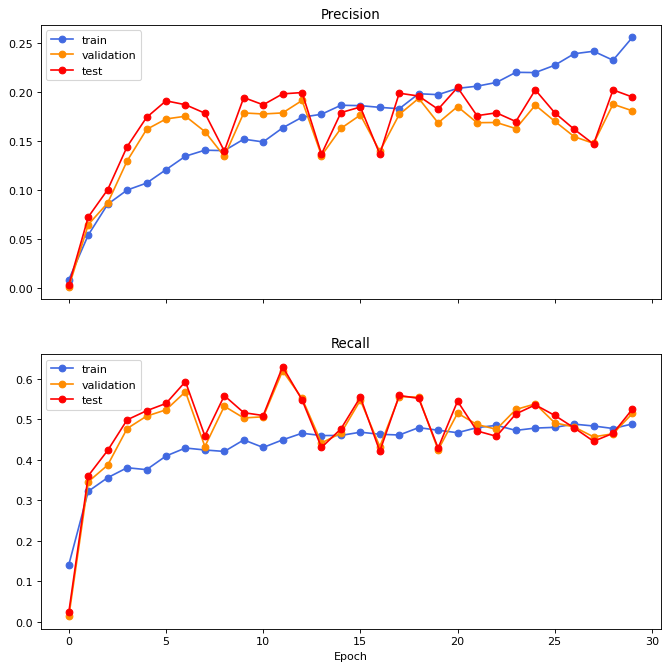

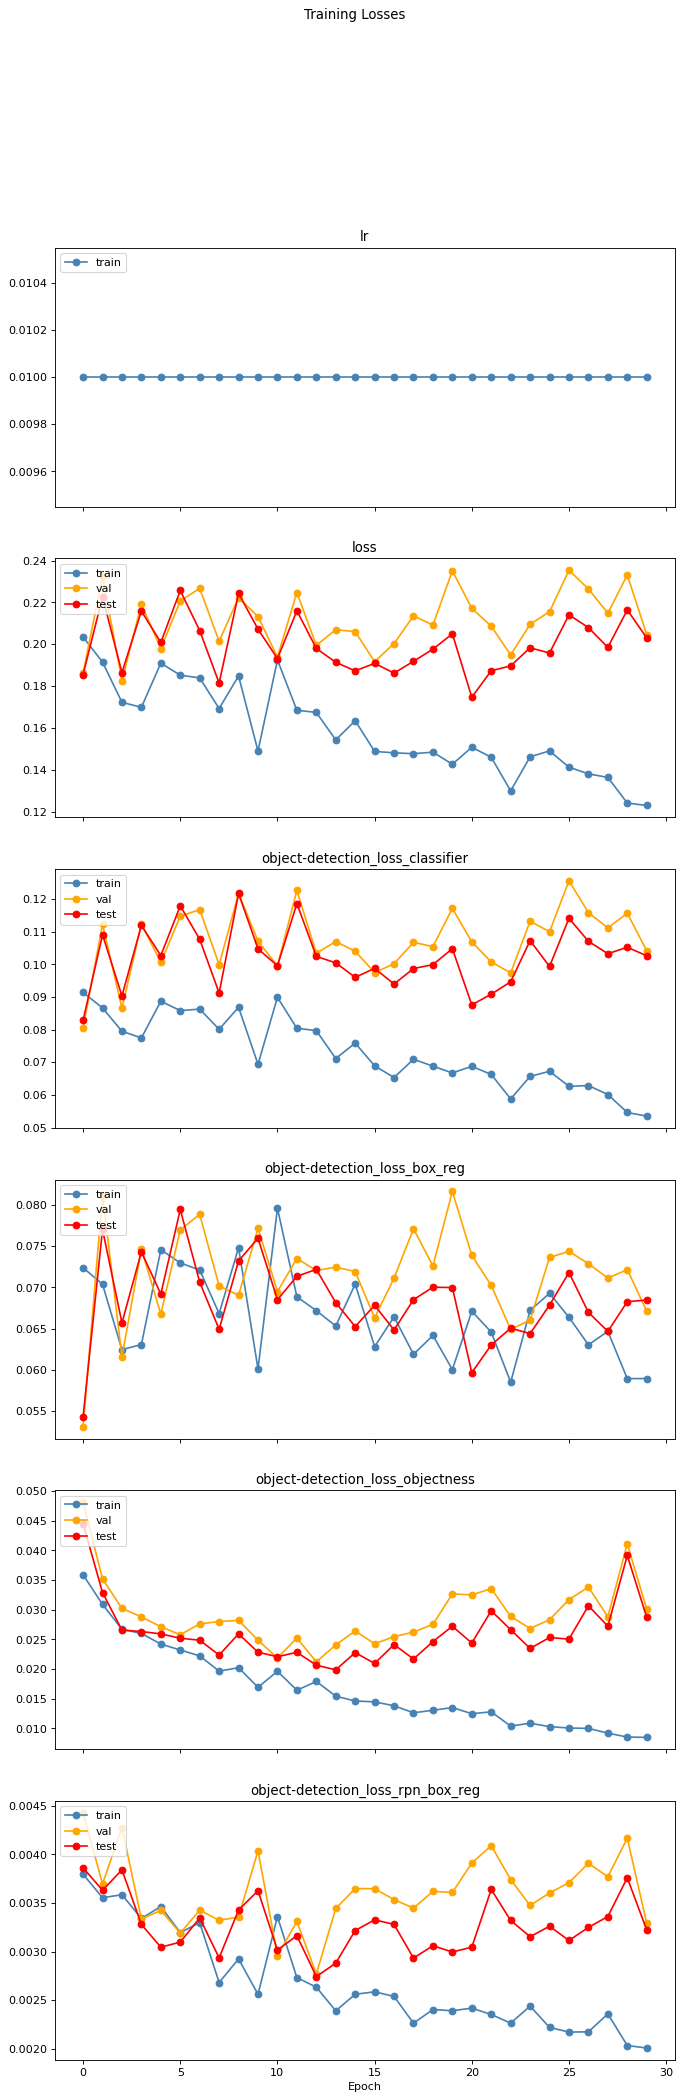

In [ ]:
for train_info in train_infos:
    print(train_info)
    model_setup: ModelSetup = train_info.model_setup
    model = create_model_from_setup(
        model_setup
    )
    
    print_params_setup(model)

    print(
        f"Max AP on test: [{max([ap_ar['ap']  for ap_ar in  train_info.test_ap_ars]):.4f}]"
    )
    plot_ap_ars(
        train_ap_ars=train_info.train_ap_ars,
        val_ap_ars=train_info.val_ap_ars,
        test_ap_ars=train_info.test_ap_ars,
    )

    plot_losses(
        train_info.train_losses,
        train_info.val_losses,
        test_logers=train_info.test_losses,
    )

